In [2]:
# Core
import re
import pandas as pd
import numpy as np
import pickle
import csv

import nltk, spacy, string
from pprint import pprint

pd.set_option("display.max_colwidth", -1)

## NLTK 
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
Pstemmer = nltk.stem.PorterStemmer()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

import gensim
from gensim import corpora, models, similarities
from gensim.utils import lemmatize
from gensim.models.coherencemodel import CoherenceModel

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE


from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import chi2_contingency

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allisonkelly/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allisonkelly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/allisonkelly/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/allisonkelly/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
dog_data_SF_19_full = pd.read_csv("Model_Data/dog_data_SF_ready.csv")

In [5]:
dog_data_SF_19_full = dog_data_SF_19_full.dropna(subset=['desc_full_clean'])

In [6]:
sum(pd.isnull(dog_data_SF_19_full["desc_full_clean"]))

0

In [7]:
pd.pivot_table(
    dog_data_SF_19_full[["time_adpt_med", "time_in_shelter"]],
    columns="time_adpt_med",
    aggfunc=np.min
)

time_adpt_med,0,1
time_in_shelter,10.0,0.0


### Extract pet names and city names to extract from text

In [6]:
len(dog_data_SF_19_full['name'].unique())

9848

In [7]:
names_split = [word.split(' ')[0].lower() for word in dog_data_SF_19_full['name'] ]
print(len(names_split))
names_unq = list(set(names_split))
print(len(names_unq))


22414
7005


In [8]:
len(dog_data_SF_19_full['contact.address.city'].unique())

121

In [9]:
city_split = [word.lower() for word in dog_data_SF_19_full['contact.address.city'] ]
print(len(city_split))
cities_unq = list(set(city_split))
print(len(cities_unq))

22414
116


### Prepare text for use in topic modeling: tokenize, lemmatize, stem

In [98]:
def lemmatization(text, postags=["ADJ"]):
    texts_out = [
        token.lemma_ if token.lemma_ not in ["-PRON-"] else ""
        for token in nlp(text)
        if token.pos_ in postags
    ]
    return texts_out


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load("en", disable=["parser", "ner"])

In [99]:
dog_data_SF_19_full["desc_lemm_adj"] = dog_data_SF_19_full["desc_full_clean"].apply(
    lemmatization
)

In [459]:
other_words = names_unq + cities_unq

pd.DataFrame(other_words).to_csv("stop_words_full.csv", index=False)

In [100]:
swfull = stopwords.words("english") + names_unq + cities_unq

def stop_wrds(text_str):
    if len(text_str) != 0:
        return [word.lower() for word in text_str if word not in swfull]

In [465]:
other_words = pd.read_csv("stop_words_full.csv")


In [474]:
[stopwords.words("english")] + [other_words['0']]

[['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  'her',
  'hers',
  'herself',
  'it',
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again',
  'further',
  'then',
  'once',
  'here',
  'there',
  'when',
  'where',
  'why',
  'how',
  'all

In [472]:
other_words['0']


0       chili         
1       nash          
2       kansas        
3       talullah      
4       gladys        
5       anita         
6       *shubis       
7       hazel         
8       tomi          
9       glen          
10      wingnut       
11      1117-1713     
12      kathleen      
13      fluffer       
14      ledson        
15      howdy         
16      eggsy         
17      gabriel       
18      nellie        
19      beau          
20      fish          
21      mittens       
22      weezy         
23      vivianne      
24      cloe-foster   
25      delight       
26      lenny         
27      buba          
28      guppy         
29      tac           
       ...            
7091    escalon       
7092    santa cruz    
7093    berkeley      
7094    auburn        
7095    napa          
7096    windsor       
7097    clayton       
7098    rocklin       
7099    felton        
7100    alameda       
7101    vacaville     
7102    san mateo     
7103    mon

In [101]:
dog_data_SF_19_full["desc_lemm_st"] = dog_data_SF_19_full["desc_lemm_adj"].apply(
    stop_wrds
)

In [102]:
def token_stem(text_str):
    if len(text_str) != 0:
        list_tok = [word for word in text_str if len(word) > 2]
        return [Pstemmer.stem(word) for word in list_tok]

In [103]:
dog_data_SF_19_full = dog_data_SF_19_full.dropna(subset=["desc_lemm_st"])

In [104]:
dog_data_SF_19_full["desc_lemm_adj"] = dog_data_SF_19_full["desc_lemm_st"].apply(
    token_stem
)

In [105]:
#dog_data_SF_19_full["desc_lemm_adj"].head(10)

In [106]:
adj_words = dog_data_SF_19_full["desc_lemm_adj"]

In [107]:
adj_words = adj_words[pd.isnull(adj_words) == False]

In [131]:
adj_words.shape

(21144,)

In [ ]:
dictionary_descr_adj = corpora.Dictionary(adj_words)

desc_adj_tfidf = models.TfidfModel(corpus_descr_adj)

corpus_adj_tfidf = desc_adj_tfidf[corpus_descr_adj]


In [ ]:
dictionary_descr_adj

### Model Diagnostics

In [40]:
## This was used to select the best pos subset 
# score_tracking = {}

# def score_lda(
#     model_name,
#     model=lda_model_adj_tfidf,
#     corpus=corpus_adj_tfidf,
#     dictionary=dictionary_descr_adj,
# ):
#     coherence_model_lda = CoherenceModel(
#         model=lda_model_adj_tfidf,
#         corpus=corpus_adj_tfidf,
#         dictionary=dictionary_descr_adj,
#         coherence="u_mass",
#     )
    
#     score_tracking[model_name] = coherence_model_lda.get_coherence()
#     return coherence_model_lda.get_coherence()
    

In [114]:
score_lda('TFIDF_A')

-6.148945605199138

In [115]:
score_tracking

{'TFIDF_A_A-V': -3.657436360905255,
 'TFIDF_A_A_V_N': -3.2571391549865925,
 'TFIDF_A_A_N': -4.788080693919544,
 'TFIDF_A_A': -5.013775332698515,
 'TFIDF_A': -6.148945605199138}

In [122]:
pd.DataFrame.from_dict(score_tracking, orient="index").to_csv("model_testing_coherence.csv")

### Optimize number of topics

In [123]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            chunksize=10,
            passes=10,
            alpha="symmetric",
            iterations=100,
            per_word_topics=True,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, corpus=corpus, dictionary=dictionary, coherence="u_mass"
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [124]:
model_list, coherence_vals = compute_coherence_values(
    dictionary_descr_adj, corpus_adj_tfidf, limit=40, step=3
)

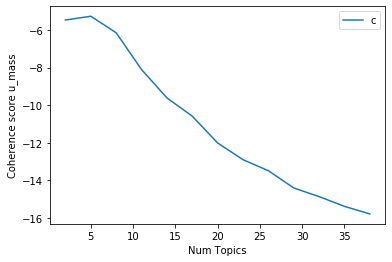

In [135]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score u_mass")
plt.legend(("coherence_values"), loc='best')
plt.show()

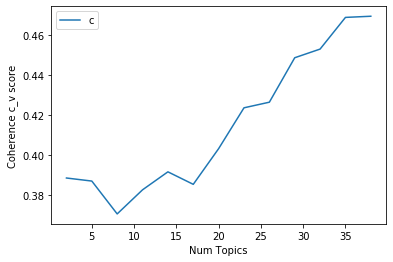

In [140]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Num Topics")
plt.ylabel("Coherence c_v score")
plt.legend(("coherence_values"), loc='best')
plt.show()

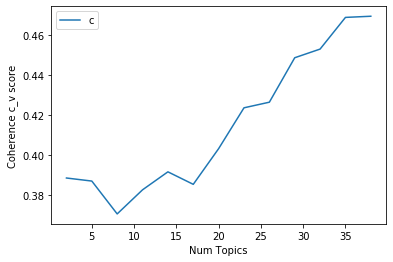

In [140]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Num Topics")
plt.ylabel("Coherence c_v score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Bigger steps

In [501]:
model_list_long, coherence_vals_long = compute_coherence_values(
    dictionary_descr_adj, corpus_adj_tfidf, limit=80, step=6
)

In [504]:
model_list_long

In [505]:
coherence_vals_long


[0.3886737494374515,
 0.37076723725127103,
 0.3917536305631727,
 0.40332001393472827,
 0.4264814154271992,
 0.45296698915418204,
 0.46934311094932635,
 0.482276569156151,
 0.4694355342206332,
 0.4567317036926864,
 0.47503637375578195,
 0.5006711944669819,
 0.496033591703352]

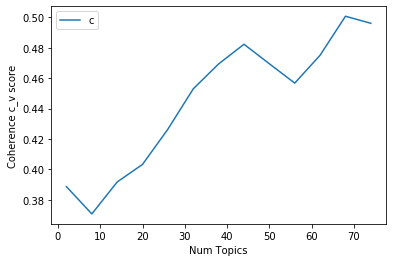

In [503]:
limit=80; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_vals_long)
plt.xlabel("Num Topics")
plt.ylabel("Coherence c_v score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [506]:
model_list_long[7].print_topics(num_words=5)

[(4,
  '0.253*"typic" + 0.112*"open" + 0.103*"endear" + 0.078*"refund" + 0.075*"option"'),
 (12,
  '0.251*"possibl" + 0.118*"reactiv" + 0.090*"needi" + 0.088*"constant" + 0.054*"complimentari"'),
 (32,
  '0.277*"outgo" + 0.107*"enough" + 0.080*"sturdi" + 0.077*"grate" + 0.069*"easygo"'),
 (33,
  '0.299*"femal" + 0.249*"human" + 0.149*"furri" + 0.085*"outsid" + 0.043*"sick"'),
 (23,
  '0.420*"adopt" + 0.244*"most" + 0.118*"lost" + 0.041*"recent" + 0.037*"back"'),
 (30,
  '0.464*"amaz" + 0.249*"fine" + 0.036*"spri" + 0.030*"incred" + 0.028*"use"'),
 (42,
  '0.498*"readi" + 0.414*"play" + 0.038*"hard" + 0.009*"lap" + 0.002*"hand"'),
 (13,
  '0.851*"previou" + 0.056*"hair" + 0.004*"clingi" + 0.000*"namei" + 0.000*"nimbl"'),
 (40,
  '0.108*"close" + 0.103*"funni" + 0.084*"respect" + 0.076*"substanti" + 0.076*"second"'),
 (11,
  '0.195*"nervou" + 0.098*"rare" + 0.097*"defens" + 0.067*"origin" + 0.051*"raw"'),
 (3,
  '0.234*"will" + 0.135*"excit" + 0.096*"awesom" + 0.083*"addit" + 0.064*"reas

### Export topics

In [429]:
model_list[5].print_topics(num_words=20)

[(0,
  '0.455*"interest" + 0.087*"activ" + 0.075*"short" + 0.066*"chip" + 0.060*"smart" + 0.039*"full" + 0.031*"grown" + 0.028*"leash" + 0.026*"medic" + 0.018*"senior" + 0.018*"fantast" + 0.016*"social" + 0.013*"mouthi" + 0.010*"pet" + 0.007*"tall" + 0.006*"privat" + 0.005*"unwant" + 0.004*"strike" + 0.002*"incredi" + 0.001*"public"'),
 (1,
  '0.432*"slow" + 0.264*"fit" + 0.092*"doesn" + 0.031*"next" + 0.022*"picki" + 0.020*"size" + 0.020*"absolut" + 0.016*"cold" + 0.011*"vet" + 0.006*"gener" + 0.006*"comfi" + 0.006*"excess" + 0.005*"pekinges" + 0.002*"horrif" + 0.002*"aw" + 0.002*"girlish" + 0.001*"critic" + 0.000*"distrust" + 0.000*"arthrit" + 0.000*"outlandishli"'),
 (2,
  '0.121*"quiet" + 0.072*"unknown" + 0.054*"afford" + 0.052*"due" + 0.046*"like" + 0.029*"dental" + 0.026*"delight" + 0.026*"busi" + 0.023*"tough" + 0.023*"defens" + 0.021*"fear" + 0.020*"fragil" + 0.020*"okay" + 0.020*"bitti" + 0.020*"mischiev" + 0.019*"recent" + 0.019*"green" + 0.018*"domin" + 0.016*"less" + 0.016

In [425]:
topic_details = pd.DataFrame((model_list[5].print_topics(num_words=20)))

In [428]:
# topic_details.head()

In [427]:
topic_details.to_csv("topics_files.csv")

In [369]:
## pickle up the model 

filename_mdl = 'lda_model_17_tps.sav'
pickle.dump(model_list[5], open(filename_mdl, 'wb'))

filename_dct = 'lda_dict_17_tps.sav'
pickle.dump(dictionary_descr_adj, open(filename_dct, 'wb'))


### Visualize the topics

In [430]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(model_list[5], corpus_adj_tfidf, dictionary_descr_adj)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.085424 -0.241600  1       1        8.568562
0      0.128348 -0.349301  2       1        8.374374
9      0.054983 -0.010404  3       1        7.431584
4      0.066329  0.039761  4       1        5.930667
15     0.026203  0.040922  5       1        5.908185
7      0.036251  0.056137  6       1        5.882189
11     0.034181  0.069991  7       1        5.829052
3      0.044197  0.048790  8       1        5.726269
16     0.004623  0.081431  9       1        5.548775
2      0.035625  0.067880  10      1        5.540706
10     0.038080  0.064093  11      1        5.391092
1      0.044532  0.015550  12      1        5.367656
13     0.023942  0.089487  13      1        5.210245
5     -0.315446 -0.047723  14      1        5.052765
12     0.033963  0.067974  15      1        5.026500
6     -0.350175 -0.084245  16      1        4.680438
14     0.008941  0.091257  17      1        4.530945, topic_info=     Category         Freq       Term        Total  loglift  logprob
11    Default  1781.000000  interest   1781.000000  30.0000  30.0000
73    Default  1083.000000  slow       1083.000000  29.0000  29.0000
69    Default  975.000000   offici     975.000000   28.0000  28.0000
19    Default  847.000000   friendli   847.000000   27.0000  27.0000
55    Default  693.000000   well       693.000000   26.0000  26.0000
54    Default  793.000000   readi      793.000000   25.0000  25.0000
72    Default  664.000000   fit        664.000000   24.0000  24.0000
53    Default  655.000000   play       655.000000   23.0000  23.0000
78    Default  687.000000   current    687.000000   22.0000  22.0000
34    Default  533.000000   adopt      533.000000   21.0000  21.0000
17    Default  587.000000   avail      587.000000   20.0000  20.0000
22    Default  570.000000   sure       570.000000   19.0000  19.0000
74    Default  580.000000   previou    580.000000   18.0000  18.0000
129   Default  428.000000   amaz       428.000000   17.0000  17.0000
45    Default  418.000000   femal      418.000000   16.0000  16.0000
2     Default  435.000000   mani       435.000000   15.0000  15.0000
149   Default  372.000000   first      372.000000   14.0000  14.0000
23    Default  356.000000   wonder     356.000000   13.0000  13.0000
26    Default  322.000000   favorit    322.000000   12.0000  12.0000
191   Default  313.000000   quiet      313.000000   11.0000  11.0000
234   Default  310.000000   most       310.000000   10.0000  10.0000
76    Default  308.000000   high       308.000000   9.0000   9.0000 
7     Default  340.000000   activ      340.000000   8.0000   8.0000 
71    Default  284.000000   larg       284.000000   7.0000   7.0000 
79    Default  326.000000   easi       326.000000   6.0000   6.0000 
107   Default  277.000000   affection  277.000000   5.0000   5.0000 
38    Default  277.000000   human      277.000000   4.0000   4.0000 
27    Default  267.000000   healthi    267.000000   3.0000   3.0000 
90    Default  260.000000   long       260.000000   2.0000   2.0000 
131   Default  247.000000   fine       247.000000   1.0000   1.0000 
...       ...         ...    ...              ...      ...      ... 
231   Topic17  143.712265   sensit     144.680313   3.0875  -2.6897 
120   Topic17  119.620018   experienc  120.588066   3.0862  -2.8732 
226   Topic17  100.939781   reserv     101.907829   3.0847  -3.0430 
122   Topic17  86.820656    poor       87.788704    3.0832  -3.1937 
263   Topic17  74.196701    outdoor    75.164749    3.0813  -3.3508 
210   Topic17  64.731323    loud       65.699371    3.0794  -3.4873 
211   Topic17  62.698845    pregnant   63.666893    3.0789  -3.5192 
711   Topic17  59.673328    dead       60.641376    3.0781  -3.5686 
506   Topic17  47.046616    lone       48.014664    3.0739  -3.8064 
237   Topic17  46.834438    mild       47.802486    3.0738  -3.8109 
209   Topic17  44.606697    huge       45.574745    

In [373]:
the_model = model_list[5]

In [541]:
test_corp = dictionary_descr_adj.doc2bow(
    [
        "Outgoing",
        "Amazing",
        "energetic",
        "trainable",
        "Typical",
        "puppy",
        "Confident",
        "loyal",
        "Quiet",
        "delightful",
        "Wonderful",
        "affectionate",
        "nice",
        "Playful",
        "Calm",
        "Active",
        "Smart",
        "Strong",
        "secure",
        "Ideal",
        "Easy",
        "going",
    ]
)

In [544]:
test = pd.DataFrame(model_list[5].get_document_topics(test_corp, minimum_probability=0.08))

In [545]:
test

,0,1
0,11,0.352941
1,13,0.352941


In [546]:
# model_list[5].get_document_topics(['ugly'], minimum_probability=0.0)

### Predict out, merge with all data and export for modeling

In [157]:
lda_adj_topics = model_list[5].get_document_topics(corpus_adj_tfidf, minimum_probability=0.0)

In [494]:
list_top = pd.DataFrame(lda_adj_topics[0])[0]

In [497]:
list_top[3]

3

In [499]:
len([top for top in list_top if top in [0,2,3,4,6,7,8,9,10,11,12,13,16]])


13

In [158]:
adj_words_df =pd.DataFrame(adj_words)
adj_words_df['all_index'] = adj_words_df.index
adj_words_df = adj_words_df.reindex(range(0,21938))
adj_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21938 entries, 0 to 21937
Data columns (total 2 columns):
desc_lemm_adj    20680 non-null object
all_index        20680 non-null float64
dtypes: float64(1), object(1)
memory usage: 342.9+ KB


In [159]:
lda_topics_df  = pd.DataFrame(lda_adj_topics)

In [160]:
lda_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21144 entries, 0 to 21143
Data columns (total 17 columns):
0     21144 non-null object
1     21144 non-null object
2     21144 non-null object
3     21144 non-null object
4     21144 non-null object
5     21144 non-null object
6     21144 non-null object
7     21144 non-null object
8     21144 non-null object
9     21144 non-null object
10    21144 non-null object
11    21144 non-null object
12    21144 non-null object
13    21144 non-null object
14    21144 non-null object
15    21144 non-null object
16    21144 non-null object
dtypes: object(17)
memory usage: 2.7+ MB


In [161]:
all_data_topics_df = pd.concat([adj_words_df, lda_topics_df], axis=1)

In [162]:
all_data_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21938 entries, 0 to 21937
Data columns (total 19 columns):
desc_lemm_adj    20680 non-null object
all_index        20680 non-null float64
0                21144 non-null object
1                21144 non-null object
2                21144 non-null object
3                21144 non-null object
4                21144 non-null object
5                21144 non-null object
6                21144 non-null object
7                21144 non-null object
8                21144 non-null object
9                21144 non-null object
10               21144 non-null object
11               21144 non-null object
12               21144 non-null object
13               21144 non-null object
14               21144 non-null object
15               21144 non-null object
16               21144 non-null object
dtypes: float64(1), object(18)
memory usage: 3.2+ MB


In [166]:
all_data_topics_df.columns = [
    "desc_lemm_adj",
    "all_index",
    "topic_1",
    "topic_2",
    "topic_3",
    "topic_4",
    "topic_5",
    "topic_6",
    "topic_7",
    "topic_8",
    "topic_9",
    "topic_10",
    "topic_11",
    "topic_12",
    "topic_13",
    "topic_14",
    "topic_15",
    "topic_16",
    "topic_17"
]

In [167]:
dog_data_SF_w_tps = dog_data_SF_19_full.merge(
    all_data_topics_df,
    how="inner",
    left_index=True,
    right_on='all_index'
)

In [168]:
dog_data_SF_w_tps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20680 entries, 0 to 21937
Data columns (total 93 columns):
num_photo                     20680 non-null int64
url                           20680 non-null object
age                           20680 non-null object
gender                        20680 non-null object
size                          20680 non-null object
coat                          17494 non-null object
name                          20680 non-null object
status                        20680 non-null object
breeds.primary                20680 non-null object
breeds.mixed                  20680 non-null int64
colors.primary                17414 non-null object
attributes.spayed_neutered    20680 non-null int64
attributes.house_trained      20680 non-null int64
attributes.special_needs      20680 non-null int64
attributes.shots_current      20680 non-null int64
environment.children          10504 non-null object
environment.dogs              13089 non-null object
environment.c

In [179]:
dog_data_SF_w_tps = dog_data_SF_w_tps.dropna(subset=["topic_1"])


In [180]:
sum(dog_data_SF_w_tps['desc_lemm_adj_x'] == dog_data_SF_w_tps['desc_lemm_adj_y'])

19933

In [181]:
dog_data_SF_w_tps['topic_17'][1][1]

0.016368382

In [256]:
def convert_topic_val(topic_tpl, thres_topc=0.2):
    value = topic_tpl[1]
    if value > thres_topc:
        return 1
    else:
        return 0

In [257]:
for row in [
    "topic_1",
    "topic_2",
    "topic_3",
    "topic_4",
    "topic_5",
    "topic_6",
    "topic_7",
    "topic_8",
    "topic_9",
    "topic_10",
    "topic_11",
    "topic_12",
    "topic_13",
    "topic_14",
    "topic_15",
    "topic_16",
    "topic_17"
]:
    dog_data_SF_w_tps[row + "_val"] = dog_data_SF_w_tps[row].apply(convert_topic_val)

In [431]:
def convert_val(topic_tpl):
    return topic_tpl[1]

for row in [
    "topic_1",
    "topic_2",
    "topic_3",
    "topic_4",
    "topic_5",
    "topic_6",
    "topic_7",
    "topic_8",
    "topic_9",
    "topic_10",
    "topic_11",
    "topic_12",
    "topic_13",
    "topic_14",
    "topic_15",
    "topic_16",
    "topic_17"
]:
    dog_data_SF_w_tps[row + "_val_full"] = dog_data_SF_w_tps[row].apply(convert_val)

In [448]:
dog_data_SF_w_tps['topic_11_val_full'].describe()

count    19933.000000
mean     0.052010    
std      0.077833    
min      0.007903    
25%      0.017681    
50%      0.022260    
75%      0.029412    
max      0.609891    
Name: topic_11_val_full, dtype: float64

In [475]:
# dog_data_SF_w_tps['desc_full_clean'][dog_data_SF_w_tps['topic_11_val_full'] > 0.6]

In [258]:
dog_data_SF_w_tps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19933 entries, 0 to 21143
Columns: 110 entries, num_photo to topic_17_val
dtypes: float64(3), int64(67), object(40)
memory usage: 17.5+ MB


In [259]:
dog_data_SF_w_tps.to_csv("Model_Data/dog_data_w_tpcs_3_17_tps.csv")



## Initial validation

In [260]:
tags_col = [
    "tags_top_active",
    "tags_top_loving",
    "tags_top_playful",
    "tags_top_sweet",
    "tags_top_friendly",
]


top_row = [
    "topic_1_val",
    "topic_2_val",
    "topic_3_val",
    "topic_4_val",
    "topic_5_val",
    "topic_6_val",
    "topic_7_val",
    "topic_8_val",
    "topic_9_val",
    "topic_10_val",
    "topic_11_val",
    "topic_12_val",
    "topic_13_val",
    "topic_14_val",
    "topic_15_val",
    "topic_16_val",
    "topic_17_val",
]

In [266]:
dog_data_SF_w_tps[top_row].describe()

,topic_1_val,topic_2_val,topic_3_val,topic_4_val,topic_5_val,topic_6_val,topic_7_val,topic_8_val,topic_9_val,topic_10_val,topic_11_val,topic_12_val,topic_13_val,topic_14_val,topic_15_val,topic_16_val,topic_17_val
count,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000
mean,0.126173,0.107360,0.059148,0.056740,0.072593,0.053379,0.061958,0.061757,0.126123,0.085436,0.058245,0.067275,0.049115,0.050971,0.041389,0.052877,0.055335
std,0.332052,0.309578,0.235908,0.231351,0.259474,0.224793,0.241084,0.240720,0.331996,0.279537,0.234212,0.250505,0.216113,0.219944,0.199192,0.223794,0.228639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [274]:
dog_data_SF_w_tps[tags_col].describe()

,tags_top_active,tags_top_loving,tags_top_playful,tags_top_sweet,tags_top_friendly
count,19933.000000,19933.000000,19933.000000,19933.000000,19933.000000
mean,0.003110,0.068530,0.033713,0.016555,0.016505
std,0.055686,0.252659,0.180494,0.127602,0.127411
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [288]:
table = pd.pivot_table(dog_data_SF_w_tps, values= top_row, index= tags_col, aggfunc=np.mean)

In [289]:
round(table,2)

topic_10_val  \
tags_top_active tags_top_loving tags_top_playful tags_top_sweet tags_top_friendly                 
0               0               0                0              0                  0.09           
                                                                1                  0.08           
                                                 1              0                  0.05           
                                1                0              0                  0.09           
                1               0                0              0                  0.07           
1               0               0                0              0                  0.13           

                                                                                   topic_11_val  \
tags_top_active tags_top_loving tags_top_playful tags_top_sweet tags_top_friendly                 
0               0               0                0              0                  0.06           
                                                                1                  0.05           
                                                 1              0                  0.02           
                                1                0              0                  0.06           
                1               0                0              0                  0.06           
1               0               0                0              0                  0.08           

                                                                                   topic_12_val  \
tags_top_active tags_top_loving tags_top_playful tags_top_sweet tags_top_friendly                 
0               0               0                0              0                  0.07           
                                                                1                  0.06           
                                                 1              0                  0.07           
                                1                0              0                  0.05           
                1               0                0              0                  0.07           
1               0               0                0              0                  0.10           

                                                                                   topic_13_val  \
tags_top_active tags_top_loving tags_top_playful tags_top_sweet tags_top_friendly                 
0               0               0                0              0                  0.05           
                                                                1                  0.05           
                                                 1              0                  0.06           
                                1                0              0                  0.06           
                1               0                0              0                  0.06           
1               0               0                0              0                  0.03           

                                                                                   topic_14_val  \
tags_top_active tags_top_loving tags_top_playful tags_top_sweet tags_top_friendly                 
0               0               0                0              0                  0.05           
                                                                1                  0.05           
                                                 1              0                  0.05           
                                1                0              0                  0.04           
                1               0                0              0                  0.05           
1               0               0                0              0                  0.06           

                                                                                   topic_15_val  \
tags_top_active tag

In [334]:
def topic_tag_test(topic, tag):
    contingency = pd.crosstab(dog_data_SF_w_tps[topic], dog_data_SF_w_tps[tag])
    c, p, dof, expected = chi2_contingency(contingency)
    percent_match = round(
        contingency[1][1] / (contingency[1][1] + contingency[1][0]), 3
    )
    gen_pop_percent = round(
        contingency[0][1] / (contingency[0][1] + contingency[0][0]), 3
    )
    print(contingency)
    print("P-value ", round(p, 5))
    print("Percent match: ", percent_match)
    print("General match: ", gen_pop_percent)

    return

In [359]:
topic_tag_test('topic_17_val', 'tags_top_loving') ### loving

tags_top_loving      0     1
topic_17_val                
0                17557  1273
1                1010   93  
P-value  0.03811
Percent match:  0.068
General match:  0.054


In [352]:
topic_tag_test('topic_7_val', 'tags_top_friendly')  ### Maybe friendly?

tags_top_friendly      0    1
topic_7_val                  
0                  18398  300
1                  1206   29 
P-value  0.06127
Percent match:  0.088
General match:  0.062


In [354]:
topic_tag_test('topic_10_val', 'tags_top_sweet') ## NOT sweet

tags_top_sweet      0    1
topic_10_val              
0               17917  313
1               1686   17 
P-value  0.0337
Percent match:  0.052
General match:  0.086


In [355]:
topic_tag_test('topic_11_val', 'tags_top_sweet') ## also not sweet

tags_top_sweet      0    1
topic_11_val              
0               18450  322
1               1153   8  
P-value  0.01105
Percent match:  0.024
General match:  0.059


In [353]:
topic_tag_test('topic_9_val', 'tags_top_playful') ## topic 9 and playful

tags_top_playful      0    1
topic_9_val                 
0                 16852  567
1                 2409   105
P-value  0.01959
Percent match:  0.156
General match:  0.125


In [357]:
topic_tag_test('topic_12_val', 'tags_top_playful') ### not playful

tags_top_playful      0    1
topic_12_val                
0                 17953  639
1                 1308   33 
P-value  0.0666
Percent match:  0.049
General match:  0.068


In [358]:
topic_tag_test('topic_15_val', 'tags_top_playful') ### similar to playful?

tags_top_playful      0    1
topic_15_val                
0                 18475  633
1                 786    39 
P-value  0.03525
Percent match:  0.058
General match:  0.041


In [360]:
topic_tag_test('topic_10_val', 'tags_top_active') 

tags_top_active      0   1
topic_10_val              
0                18176  54
1                1695   8 
P-value  0.31613
Percent match:  0.129
General match:  0.085


In [507]:
empy = []

In [508]:
len(empy)

0